In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
#忽略警告信息
import warnings
warnings.filterwarnings('ignore')

# 数据预处理

In [2]:
#读取数据
df = pd.read_csv("Mall_Customers.csv")
#查看数据情况
print(df.info())

In [3]:
#去除重复值
df.drop_duplicates(inplace = True)
# 将性别变量数值化
gender_dic = {"Female":0,"Male":1}
df["Gender"] = df["Gender"].map(gender_dic)
print(df.head())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1       1   19                  15                      39
1           2       1   21                  15                      81
2           3       0   20                  16                       6
3           4       0   23                  16                      77
4           5       0   31                  17                      40


# 列变量相关性分析

TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

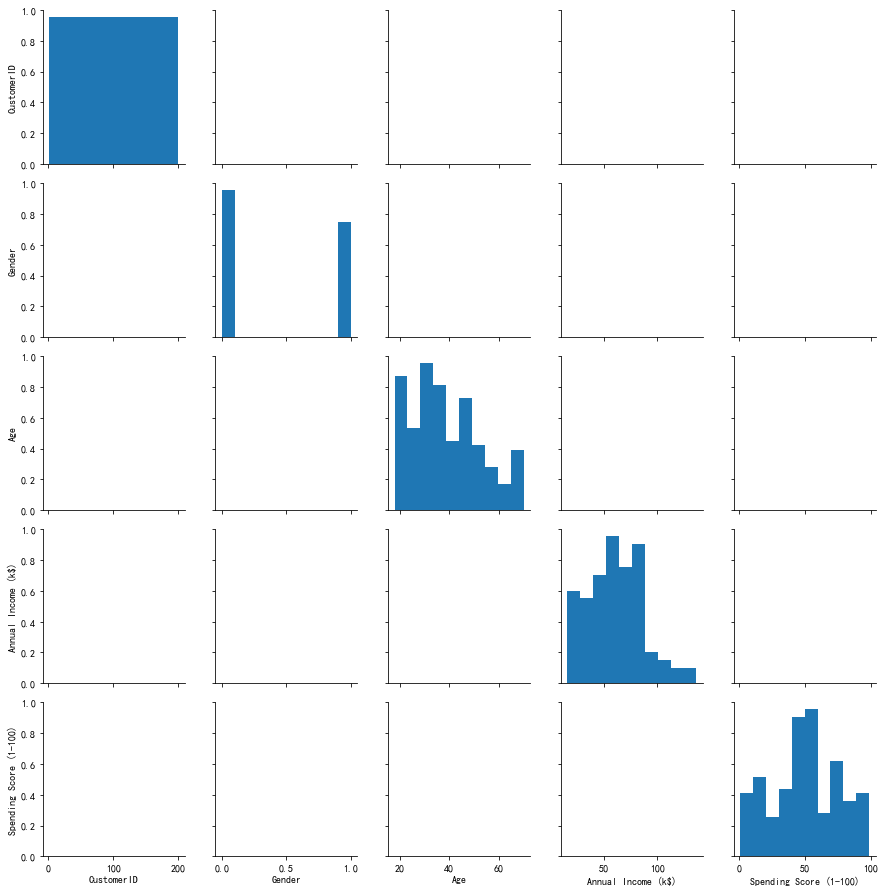

In [4]:
# 可视化变量之间的相关性
sns.pairplot(df) # 变量之间不存在明显的相关性

In [5]:
# 计算性别和消费得分之间点二列相关系数
from scipy import stats
print(stats.pointbiserialr(df["Gender"],df["Spending Score (1-100)"]))
# 结果表明二者不具有明显的相关性，聚类时排除性别字段

PointbiserialrResult(correlation=-0.05810873926162081, pvalue=0.4137446589852207)


In [7]:
# 选取特征进行聚类
data = df[["Age", "Annual Income (k$)", "Spending Score (1-100)"]]
print(data.head())

   Age  Annual Income (k$)  Spending Score (1-100)
0   19                  15                      39
1   21                  15                      81
2   20                  16                       6
3   23                  16                      77
4   31                  17                      40


D:\anaconda\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
D:\anaconda\lib\site-packages\sklearn\linear_model\least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=True, fit_path=True,
D:\anaconda\lib\site-pa

D:\anaconda\lib\site-packages\sklearn\metrics\pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
D:\anaconda\lib\site-packages\sklearn\metrics\pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
D:\anaconda\lib\site-packages\sklearn\metrics\pairwise.py:53: DeprecationWarning: `np.floa

D:\anaconda\lib\site-packages\sklearn\metrics\pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
D:\anaconda\lib\site-packages\sklearn\metrics\pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
D:\anaconda\lib\site-packages\sklearn\metrics\pairwise.py:53: DeprecationWarning: `np.floa

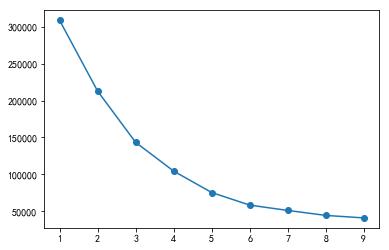

In [8]:
#根据手肘法则选取最佳聚类数
from sklearn.cluster import KMeans
SSE = []#利用误差平方和求最佳聚类数
for i in range(1,10):
    # init:初始化方法；
    # max_iter：执行一次k-means算法所进行的最大迭代数；
    km=KMeans(n_clusters=i, init = "k-means++", random_state=0)
    km.fit(data)
    SSE.append(km.inertia_)
plt.plot(range(1,10), SSE, "o-") #圆圈+线标记

In [10]:
# 使用TSNE降维可视化聚类结果
from sklearn.manifold import TSNE

#设定聚类数为6
km_model = KMeans(n_clusters=6, init = "k-means++", random_state=0)
km_model.fit(data)
labels = km_model.labels_

tsne = TSNE()
t_data = tsne.fit_transform(data) # 将数据降成两维
tsne_df = pd.DataFrame(t_data,columns=["col1","col2"])
tsne_df["label"] = labels
sns.scatterplot(x = "col1",y="col2",hue="label",data=tsne_df) #hue类别

TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

In [ ]:
# 使用轮廓系数评估聚类效果
from sklearn import metrics
score = metrics.silhouette_score(data,labels)
print("聚类个数为6时，轮廓系数为：", score)

In [ ]:
# 聚类人群可视化分析
cluster_centers=km_model.cluster_centers_
print(cluster_centers)
result = pd.DataFrame(data=cluster_centers,
                      columns = ["Age", "Annual Income(k$)","Spending Score(1-100)"]).reset_index(drop= True) #删除原行索引
#result.plot(kind="bar",color=["b1","b2","b3"],clip_on=False,alpha = 0.5)
result.plot(kind="bar",color=["C1","C2","C3"],clip_on=False,alpha = 0.5)


In [ ]:
# 不同客户群体占比可视化
data["label"] = km_model.labels_
data["label"].value_counts().plot.pie(labels = ["重要发展客户","冲动消费客户","重要保持客户",
                                                "谨慎消费客户","重要价值客户","一般价值客户"],autopct="%.1f%%")